In [12]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import random
import math
import pickle
import matplotlib.pyplot as plt
import numpy as np
import copy

In [13]:
#This class generates correlated memory vectors as decribed in (Benna, Fusi; 2021)
class CorrelatedPatterns():
    def __init__(self, 
                 L, #Length of each memory vector 
                 p, #Number of ancestors
                 k, #Number of children per ancestor
                 gamma): #Average overlap between child and ancestor. A value of one means each child is identical to its ancestor,
                        #while a value of zero means each child is completely different from its ancestor.
        self.L = L
        self.p = p
        self.k = k
        self.gamma = gamma
        
        #Create three arrays to store the ancestor vectors, the descendant (child) vectors, and the difference vectors
        self.ancestors = []
        self.descendants = []
        self.differences = []
        
        #For purposes of PyTorch dataset creation, we will create two new lists that do not themselves contain lists
        self.descendants_singlelist = []
        self.differences_singlelist = []
        
        for _ancestorIndex in range(p):
            
            #Each ancestor is initialized randomly
            ancestor = np.random.choice((-1,1), size=(L))
            self.ancestors.append(np.array(ancestor))
            
            self.descendants.append([])
            #Initialize k descendants
            for _descendantIndex in range(k):
                descendant = torch.tensor([])
                for __i in range(len(ancestor)):
                    
                    #With probability 1-gamma, the descendant memory is corrupted at this bit. 
                    if(random.uniform(0,1) < 1-gamma):
                        descendant = torch.cat((descendant, (torch.tensor([ancestor[__i]]) * -1)))
                    else: #Otherwise, the ancestor's memory at this bit is copied to the descendant.
                        descendant = torch.cat((descendant, torch.tensor([ancestor[__i]])))
                
                #Save the memory
                self.descendants[_ancestorIndex].append(descendant.clone().detach())
                self.descendants_singlelist.append(descendant.clone().detach().reshape(1,-1))
            
            #Calculate the differences between the ancestor vectors and the child vectors
            self.differences.append([])
            for _descendantIndex in range(k):
                self.differences[_ancestorIndex].append(torch.tensor(self.ancestors[_ancestorIndex]) - self.descendants[_ancestorIndex][_descendantIndex])
                self.differences_singlelist.append((torch.tensor(self.ancestors[_ancestorIndex]) - self.descendants[_ancestorIndex][_descendantIndex]).reshape(1,-1))
                
        self.descendants_singlelist = torch.cat(self.descendants_singlelist)
        self.differences_singlelist = torch.cat(self.differences_singlelist)

#This subclass inherits the PyTorch Dataset class in order to create datasets of correlated memory.
class SensoryData(Dataset):
    def __init__(self, 
                 L,      #Length of each sample
                 p,      #Number of parents
                 k,      #Number of children per parent 
                 gamma,   #Overlap between parent and children (1=identical, 0=no overlap)
                 shuffle=True
                ):
        super().__init__()
        c = CorrelatedPatterns(L, p, k, gamma)
        memories = c.descendants_singlelist
        if(shuffle == True):
            memories = memories[torch.randperm(memories.shape[0])]
        #Grab the memories generated by CorrelatedPatterns()
        self.data = memories
        self.x = memories
        self.y = memories
        self.n_samples = memories.shape[0]
    
    #Implement necessary helper functions
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [14]:
high_corr_data_len10 = SensoryData(10, 10, 600, 0.9)
torch.save(high_corr_data_len10, "high_corr_dataset_len10.pt")

In [15]:
med_corr_data_len10 = SensoryData(10, 10, 600, 0.6)
torch.save(med_corr_data_len10, "med_corr_dataset_len10.pt")

In [16]:
low_corr_data_len10 = SensoryData(10, 10, 600, 0.3)
torch.save(low_corr_data_len10, "low_corr_dataset_len10.pt")

In [17]:
class Autoencoder(nn.Module):
    def __init__(self, 
                 n_inputs, #Number of input units
                 n_hiddens): #Number of hidden units
        super().__init__()
        
        self.eweight = nn.Parameter(torch.rand(n_hiddens, n_inputs), requires_grad=True)
        #self.initial_weights = self.eweight.clone()
        self.initial_state_dict = copy.deepcopy(self.state_dict())
        
        
        self.n_inputs = n_inputs
        self.n_hiddens = n_hiddens
        
    #Implement the forward pass
    def forward(self, X):
        X = torch.flatten(X, start_dim=1)
        
        self.encoded = F.linear(X, self.eweight)
        self.hidden_activations = torch.relu(self.encoded)
        
        self.decoded = F.linear(self.hidden_activations, self.eweight.T)
        self.decoder_activations = torch.tanh(self.decoded)
        return self.decoder_activations, self.hidden_activations
    


In [18]:
loader = DataLoader(high_corr_data_len10, batch_size=1, shuffle=True)

focus_array = []
ARRAY_LEN = 10
for i in range(ARRAY_LEN):
    focus_array.append(next(iter(loader)))
    
def update_focus_array():
    pop_item = focus_array.pop(0)
    push_item = next(iter(loader))
    
    focus_array.append(push_item)
    
    return push_item

In [19]:
#Function written by Huidi Li
def compute_gradmask(model, grads, ratio=0.1): 
    masks = []
    for i, p in enumerate(model.parameters()):
        grads_shape = grads[i].shape
        grads_sorted, grads_sort_idx = torch.sort(torch.abs(grads[i]).flatten())
        min_idx = int(ratio * len(grads_sorted))
        mask = abs(grads[i])<grads_sorted[min_idx]
        masks.append(mask.reshape(grads_shape))
    return masks



In [28]:
def AddNoise(array):
    
    #mask_status = torch.rand(array.shape)
    #mask_status = mask_status >= torch.sort(mask_status.flatten()).values[-1*int(arr.nelement()*(bit_mask_pct))]
    #indices = np.random.permutation(np.arange(0,array.nelement(),1))
    #array[indices[0]] = 0
    #array[indices[1]] = 0
    
    arr = copy.deepcopy(array)
    
    random_index = random.randint(0,len(arr))
    arr[random_index % len(arr)] = 0
    arr[(random_index + 1) % len(arr)] = 0
    
    return arr

def bin_thresh(tensor):
    tensor[tensor > 0] = 1
    tensor[tensor <= 0] = -1
    return tensor


def train(
            model,
            optimizer,
            loss_function,
            outer_loop_epochs=1000,
            inner_loop_epochs=100, 
            alpha=0.5,
            reset_ratio=0.7,
            report_interval=5
    
        ):
    print(f"Initializing training with ARRAY_LEN={ARRAY_LEN}")
    initial_lr = optimizer.param_groups[0]['lr']
    model.train()
    
    initial_parameters = []
    
    for param_ind, param in enumerate(model.parameters()):
        initial_parameters.append(param)
    
    
    weight_history = {}
    
    loss_history = []
    accuracy_history = []
    avg_arr_acc_history = []
    inner_loop_loss_history = []
    
    for outer_epoch in range(outer_loop_epochs):
        if(outer_epoch % report_interval == 0):
            print("Epoch ", outer_epoch)
        e_item = update_focus_array()
        
        Xs = torch.Tensor()
        Ys = torch.Tensor()
        for i in range(len(focus_array)):
            Xs = torch.cat([Xs, focus_array[i][0]])
            Ys = torch.cat([Ys, focus_array[i][1]])
        
        model_gradients_ma = []
        
        
        W_old = []
        for param_ind, param in enumerate(model.parameters()):
            W_old.append(copy.deepcopy(param))
        
        
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [inner_loop_epochs*0.25,
                                                               inner_loop_epochs*0.5,
                                                               inner_loop_epochs*0.75],
                                                                gamma=0.1,
                                                                last_epoch=-1)
        optimizer.param_groups[0]['lr'] = initial_lr
        inner_loss_timeline = []
        
        for inner_epoch in range(inner_loop_epochs):
            trial_Xs = copy.deepcopy(Xs)
            for _ in range(Xs.shape[0]):
                trial_Xs[_] = AddNoise(trial_Xs[_])
            
            predicted_y, net_hidden_activity = model(trial_Xs)
            
            loss = loss_function(predicted_y, Ys)
            inner_loss_timeline.append(loss.detach())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            for param_ind, param in enumerate(model.parameters()):
                if(inner_epoch == 0):
                    model_gradients_ma.append(torch.abs(param.grad))
                else:
                    model_gradients_ma[param_ind] = alpha*torch.abs(param.grad) + (1-alpha)*model_gradients_ma[param_ind]
        
        if(outer_epoch % report_interval == 0):
            inner_loop_loss_history.append(inner_loss_timeline)
            
        model.eval()
        with torch.no_grad():
            trial_Xs = copy.deepcopy(Xs)
            successes = 0
            trials = 0
            avg_accuracy = 0
            for _ in range(Xs.shape[0]):
                trial_Xs[_] = AddNoise(trial_Xs[_])
                predicted_y, net_hidden_activity = model(trial_Xs[_].unsqueeze(0))
                if(torch.count_nonzero(bin_thresh(predicted_y) - Ys[_]) < 1):
                    successes += 1
                trials += 1
                avg_accuracy += (ARRAY_LEN-torch.count_nonzero(bin_thresh(predicted_y) - Ys[_]))/10
                
            avg_arr_acc_history.append(avg_accuracy/ARRAY_LEN)
            loss = loss_function(predicted_y, Ys)
            loss_history.append(loss.detach())
            if(outer_epoch % report_interval == 0):
                print(f'Loss: {loss.detach()}')


                print(f'Accuracy rate: {successes}/{trials} = {successes/trials}')    
                print(f'Array average accuracy {avg_accuracy/ARRAY_LEN}')
                
                plt.plot(loss_history[-report_interval:], label='loss on the 10 array items')
                plt.plot(accuracy_history[-report_interval:], label='percentage of the 10 array items recalled correctly')
                plt.plot(avg_arr_acc_history[-report_interval:], label='average accuracy on the 10 array items')
                plt.legend()
                plt.xlabel(f"the last {report_interval} outer loop epochs")
                plt.show()
            accuracy_history.append(successes/trials)    
        model.train()
        
        W_new = []
        for param_ind, param in enumerate(model.parameters()):
            W_new.append(copy.deepcopy(param))
        
        #Save weights and mask
        mask = compute_gradmask(model, model_gradients_ma, ratio=reset_ratio)
        weight_history[outer_epoch] = {'e_item': e_item, 
                               'W_old': W_old,
                               'W_new': W_new, 
                               'gradmask': mask
                               }
        
        #Reset weights
        if(outer_epoch > 0):
            
            state_dict = model.state_dict()
            param_index = 0
            for param_name, param_value in state_dict.items():
                state_dict[param_name][mask[param_index]] = model.initial_state_dict[param_name][mask[param_index]]
                param_index += 1

            model.load_state_dict(state_dict)
        
        
        
        
    return weight_history, loss_history, accuracy_history, avg_arr_acc_history, inner_loop_loss_history

In [31]:
loader = DataLoader(high_corr_data_len10, batch_size=1, shuffle=True)

focus_array = []
ARRAY_LEN = 10
for i in range(ARRAY_LEN):
    focus_array.append(next(iter(loader)))


model = Autoencoder(10,20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-2)

loss_function = nn.MSELoss()

Initializing training with ARRAY_LEN=10
Epoch  0
Loss: 2.0
Accuracy rate: 0/10 = 0.0
Array average accuracy 0.6100000143051147


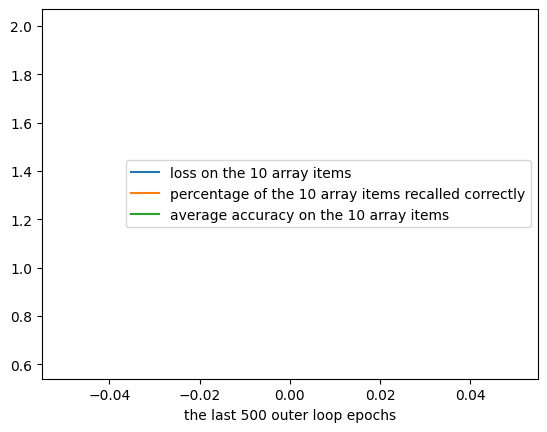

Epoch  500
Loss: 1.7599999904632568
Accuracy rate: 10/10 = 1.0
Array average accuracy 1.0


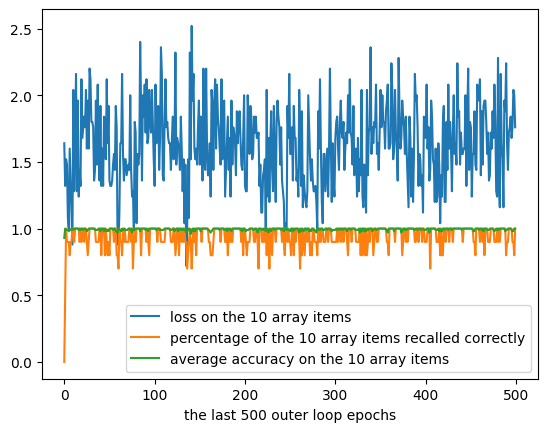

Epoch  1000
Loss: 1.3200000524520874
Accuracy rate: 10/10 = 1.0
Array average accuracy 1.0


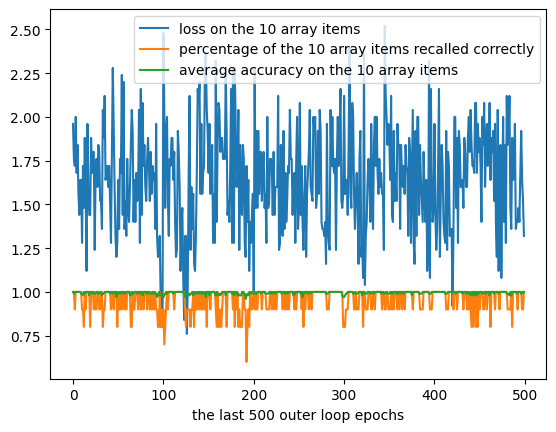

In [ ]:
output_data = train(model=model,
      optimizer=optimizer,
      loss_function=loss_function,
      outer_loop_epochs=50000,
      inner_loop_epochs=200,
      reset_ratio=0.3,
      report_interval=500
     )

In [ ]:
plt.plot(output_data[1], label='loss on the 10 array items')
plt.plot(output_data[2], label='percentage of the 10 array items recalled correctly')
plt.plot(output_data[3], label='average accuracy on the 10 array items')
plt.legend()
plt.xlabel("outer loop epoch")

In [262]:
def evaluate(model, loader):
    eval_history = []
    model.eval()
    successes = 0
    trials = 0
    for X, y in loader:
        X[0] = AddNoise(X[0])
        if(torch.count_nonzero(bin_thresh(model(X)[0]) - y) < 2):
            successes += 1
        trials += 1
        
    print(f'Accuracy rate: {successes}/{trials} = {successes/trials}')
    
def slider_evaluate(model, loader, width=10):
    eval_history = []
    current_array = []
    model.eval()
    successes = 0
    trials = 0

    for X, y in loader:
        current_array.append((X,y))
        current_
        X[0] = AddNoise(X[0])
        if(torch.count_nonzero(bin_thresh(model(X)[0]) - y) < 2):
            successes += 1
        trials += 1
        
    print(f'Accuracy rate: {successes}/{trials} = {successes/trials}')

In [263]:
evaluate(model, loader)

Accuracy rate: 1912/6000 = 0.31866666666666665


In [ ]:
with open('high_corr_arraylen_10.pkl', 'wb') as f:
    pickle.dump(output_data[0], f)

In [10]:
loader = DataLoader(med_corr_data_len10, batch_size=1, shuffle=True)

focus_array = []
ARRAY_LEN = 30
for i in range(ARRAY_LEN):
    focus_array.append(next(iter(loader)))


model = Autoencoder(10,20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

loss_function = nn.MSELoss()

In [11]:
output_data = train(model=model,
      optimizer=optimizer,
      loss_function=loss_function,
      outer_loop_epochs=6000,
      inner_loop_epochs=400
     )

In [12]:
with open('5.pkl', 'wb') as f:
    pickle.dump(output_data, f)

In [13]:
loader = DataLoader(low_corr_data_len10, batch_size=1, shuffle=True)

focus_array = []
ARRAY_LEN = 30
for i in range(ARRAY_LEN):
    focus_array.append(next(iter(loader)))


model = Autoencoder(10,20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

loss_function = nn.MSELoss()

In [14]:
output_data = train(model=model,
      optimizer=optimizer,
      loss_function=loss_function,
      outer_loop_epochs=6000,
      inner_loop_epochs=64
     )

In [15]:
with open('6.pkl', 'wb') as f:
    pickle.dump(output_data, f)

In [16]:
loader = DataLoader(high_corr_data_len10, batch_size=1, shuffle=True)

focus_array = []
ARRAY_LEN = 50
for i in range(ARRAY_LEN):
    focus_array.append(next(iter(loader)))


model = Autoencoder(10,20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

loss_function = nn.MSELoss()

In [17]:
output_data = train(model=model,
      optimizer=optimizer,
      loss_function=loss_function,
      outer_loop_epochs=6000,
      inner_loop_epochs=64
     )

In [18]:
with open('7.pkl', 'wb') as f:
    pickle.dump(output_data, f)

In [19]:
loader = DataLoader(med_corr_data_len10, batch_size=1, shuffle=True)

focus_array = []
ARRAY_LEN = 50
for i in range(ARRAY_LEN):
    focus_array.append(next(iter(loader)))


model = Autoencoder(10,20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

loss_function = nn.MSELoss()

In [20]:
output_data = train(model=model,
      optimizer=optimizer,
      loss_function=loss_function,
      outer_loop_epochs=6000,
      inner_loop_epochs=64
     )

In [21]:
with open('8.pkl', 'wb') as f:
    pickle.dump(output_data, f)

In [22]:
loader = DataLoader(low_corr_data_len10, batch_size=1, shuffle=True)

focus_array = []
ARRAY_LEN = 50
for i in range(ARRAY_LEN):
    focus_array.append(next(iter(loader)))


model = Autoencoder(10,20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

loss_function = nn.MSELoss()

In [23]:
output_data = train(model=model,
      optimizer=optimizer,
      loss_function=loss_function,
      outer_loop_epochs=6000,
      inner_loop_epochs=64
     )

In [24]:
with open('9.pkl', 'wb') as f:
    pickle.dump(output_data, f)

## Rough sketches

In [78]:
m2 = Autoencoder(10,20)

In [93]:
m2.eweight.data = output_data[0][3]['W_new'][0]

In [94]:
m2(output_data[0][3]['e_item'][0])

(tensor([[-0.9301, -0.9918,  0.9646,  0.9928, -0.9400, -0.9346, -0.8982,  0.9796,
           0.9989,  0.9749]], grad_fn=<TanhBackward0>),
 tensor([[0.0000, 0.0000, 0.1265, 0.0000, 0.7902, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 3.5699, 0.0000, 1.0360, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0728, 2.8063]], grad_fn=<ReluBackward0>))

In [95]:
output_data[0][3]

{'e_item': [tensor([[-1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.]]),
  tensor([[-1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.]])],
 'W_old': [Parameter containing:
  tensor([[ 0.3199,  0.1496,  0.4081,  0.0126,  0.1958,  0.2218, -0.1481,  0.1235,
           -0.0487,  0.1094],
          [ 0.9753,  0.4065,  0.2240,  0.8885,  0.1564,  0.1692,  0.3714,  0.6311,
            0.4690,  0.1980],
          [-0.0724,  0.6892, -0.2025,  0.6756,  0.4447, -0.1911, -0.7459, -0.3917,
           -0.4027,  0.4382],
          [ 0.1141,  0.1984,  0.5994,  0.0361, -0.2102,  0.0464,  0.8698, -0.0475,
            0.5656,  0.2585],
          [-0.6474,  0.5815,  0.1126,  0.4915, -0.2628,  0.4427,  0.4197,  0.8174,
            0.5374,  0.0764],
          [-0.8123, -0.2929, -0.4888, -0.3449,  0.2857,  0.1675,  0.1537, -0.8053,
           -0.4297,  0.5629],
          [ 0.8609,  0.7077,  0.4684,  0.1630,  0.0178,  0.1376,  0.5939,  0.9096,
            0.1398,  0.3495],
          [ 0.5124, -0.0952,  0.2016,